# Demo de implementación de un algoritmo de Bandadas de Pájaros (Particle Swarm Optimization o PSO) para resolver el problema de encontrar un Máximo Óptimo definido al azar en un plano y tratando de esquivar los máximos locales aleatorios
El código es una adaptación del ejemplo de la librería DEAP disponible en https://deap.readthedocs.io/en/master/ pero no utiliza la librería (no son necesarios los operadores ni clases) y se mejora

1) Importar librerías:

In [8]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import operator
import copy
print("\nLibrerías importadas")


Librerías importadas


2) Establecer parámetros generales de la Corrida:

In [9]:
# Cantidad de Máximos Locales
CANT_MAXIMOS_LOCALES = 3

# Espacio mínimo y máximo del espacio de búsqueda
MIN_ESPACIO_BUSQ = -1000
MAX_ESPACIO_BUSQ = 1000

# Cantidad de Ciclos de la Corrida
CANT_CICLOS = 100

# Cantidad de Particulas
CANT_PARTICULAS = 10

# Indica si se muestra el detalle de cada ciclo
MUESTRA_DETALLE = True

print("\nParámetros de la Corrida definidos")


Parámetros de la Corrida definidos


3) Especificar el objeto Particula y la Función Heurística:

In [10]:
### clase MAPA DE BÚSQUEDA

class MapaBusqueda(object):

    def __init__(self, limMin, limMax, cantMaximosLocales=0):
          self.limMin = limMin
          self.limMax = limMax
          self.cantMax = cantMaximosLocales
          self.generarPosicionesRnd()

    def generarPosicionesRnd(self):
      
        # Define Posiciones Random para Máximos Locales y Óptimos
        # con Heurística también al Azar (entre 1 y 100)
        # controla que el máximo local/global no se ubique en la misma posición que el Hormiguero
        self.MaximosPos = []
        self.MaximosVal = []
        self.MaxOptimoID = 0
        auxMejorVal = -99
        i = 0
        while len(self.MaximosPos)<(self.cantMax+1):

            auxPos = [ random.randint(self.limMin, self.limMax),  random.randint(self.limMin, self.limMax) ]        
            auxVal = random.randint(-20, 100)

            self.MaximosPos.append( auxPos )
            self.MaximosVal.append( auxVal )
            
            if self.MaximosVal[self.MaxOptimoID] < auxVal:
                self.MaxOptimoID = i
            i= i + 1

        return True
   
    def printInformacion(self):
        # Muestra la información sobre el Mapa de Búsqueda
        print("\n** Máximos Generados: ", len(self.MaximosPos))
        for auxPos, auxVal in zip(self.MaximosPos, self.MaximosVal):
            print("  -->", auxPos, "{ ", auxVal, " } ")
        print("\n** Posición Máximo Óptimo: ", self.MaximosPos[self.MaxOptimoID], " { ",  self.MaximosVal[self.MaxOptimoID]," } **")
        print("\n")

    @property
    def posMaximos(self):
        return self.MaximosPos    

    @property
    def valMaximos(self):
        return self.MaximosVal   
        
    @property
    def posMaximoGlobal(self):
        return self.MaximosPos[self.MaxOptimoID]         
    
    @property
    def valMaximoGlobal(self):
        return self.MaximosVal[self.MaxOptimoID]  

    def estaEnMaximo(self, posicion):
      # Indica si la posición corresponde o no a un Máximo 
      # si es verdadero devuelve el valor correspondiente, sino 0
      for i in range(len(self.MaximosPos)):
        if posicion==self.MaximosPos[i]:
          return self.MaximosVal[i]
      return 0

    def funcHeuristica(self, posicion):
        # Define la Función Heurística para evaluar una posicion del mapa
        devuelve = 0
        disPosMenor = self.limMax
        for posMax, valMax in zip(self.MaximosPos, self.MaximosVal):

              # calcula la distancia al punto de la Particula
              sqerrors = ((x - y)**2 for x, y in zip(posicion, posMax))
              distPos =  math.fsum(sqerrors)**0.5 / 10
              
              # Si es la menor distancia calcula la Heurística
              if disPosMenor > distPos:
                  disPosMenor = distPos 
                  devuelve = ( valMax - distPos) 

          # Por las dudas controla que devuelva un valor positivo
        return max(devuelve,0)


print("\nClase Mapa de Búqueda definida") 


Clase Mapa de Búqueda definida


In [11]:
### clase PARTICULA

class Particula(object):
    
    def __init__(self, mapa):        
        self.mapa = mapa
        self.pos = [random.randint(self.mapa.limMin, self.mapa.limMax) for _ in range(2)]
        self.valor = self.mapa.funcHeuristica(self.pos)
        self.velocidad = [random.uniform(self.mapa.limMin//10, self.mapa.limMax//10) for _ in range(len(self.pos))]
        

    def _reset(self):
        self.pos = []
        self.valor = -9999
        self.velocidad = []

    @property
    def heuristica(self):
        return self.valor

    @property
    def posicion(self):
        return self.pos   

    def moverse(self, mejorCiclo, mejorCorrida, coefAtraccMejorCiclo=1.5, coefAtraccMejorCorrida=3):
        
        for i in range(len(self.pos)):
              # calcula el desplazamiento (velocidad) en base a la atracción a la mejor del ciclo y global
            ajusteVel = (coefAtraccMejorCiclo * random.uniform(0, 1) * (mejorCiclo.posicion[i]-self.pos[i])) \
                        + (coefAtraccMejorCorrida * random.uniform(0, 1) * (mejorCorrida.posicion[i]-self.pos[i]))
            self.velocidad[i] = self.velocidad[i] + ajusteVel/10

              # ajusta la posición de la partícula (se ajusta la velocidad para que cambie de a poco)
            self.pos[i] = self.pos[i] + int(self.velocidad[i])

              # revisa no haber superado los límites del mapa
            if self.pos[i] < self.mapa.limMin:
                  self.pos[i] = self.mapa.limMin
            elif self.pos[i] > self.mapa.limMax:
                  self.pos[i] = self.mapa.limMax

          # actualiza su heurística
        self.valor = self.mapa.funcHeuristica(self.pos)
        return copy.deepcopy( self.pos )

print("\nClase Particula definida")


Clase Particula definida


4) Ejecutar la corrida del algoritmo mostrando resultados:

In [12]:
## INICIALIZA EL MAPA DE BÚSQUEDA

# Define el Mapa de Búsqueda
mapa = MapaBusqueda(limMin=MIN_ESPACIO_BUSQ, limMax=MAX_ESPACIO_BUSQ, \
                    cantMaximosLocales=CANT_MAXIMOS_LOCALES)

# Muestra su información
mapa.printInformacion()


** Máximos Generados:  4
  --> [-521, -933] {  2  } 
  --> [827, 862] {  82  } 
  --> [-654, 830] {  53  } 
  --> [-254, -392] {  -18  } 

** Posición Máximo Óptimo:  [827, 862]  {  82  } **




In [13]:
## EJECUCIÓN DE LA CORRIDA

# vectores auxiliares 
ciclo = 1    
mejorPartCiclo = None
mejorPartCorrida = None
ciclosParticulas = []
ciclosMaxAptitud = []
partPobla = []

# Define la población de las Particulas
for i in range(CANT_PARTICULAS):
  p = Particula(mapa)
  partPobla.append( p ) 
  ciclosParticulas.append( copy.deepcopy( p.posicion ) )

while (ciclo < CANT_CICLOS):

    if MUESTRA_DETALLE:
        print("\n-- Ciclo  %i --" % ciclo)        

    # Evalúa las particulas de la población para determinar las mejores 
    rankingParticulas = sorted(partPobla, key=operator.attrgetter('heuristica'), reverse=True)
    mejorPartCiclo = rankingParticulas[0]
    if mejorPartCorrida == None or mejorPartCiclo.heuristica > mejorPartCorrida.heuristica:
        # congela la particula con la mejor posición encontrada en la corrida
        mejorPartCorrida = copy.deepcopy( mejorPartCiclo ) 
    ciclosMaxAptitud.append( rankingParticulas[0].heuristica )

    if MUESTRA_DETALLE:
        print(" Mejor Partícula Ciclo:", mejorPartCiclo.posicion, " { ", mejorPartCiclo.heuristica, " } ")
        print(" Mejor Partícula Corrida:", mejorPartCorrida.posicion, " { ", mejorPartCorrida.heuristica, " } ")

    # Actualiza la posición de las partículas
    for p in partPobla:
        nuevaPos = p.moverse( mejorPartCiclo, mejorPartCorrida )
        ciclosParticulas.append( nuevaPos )

    ciclo = ciclo + 1

print("\n-- Corrida Finalizada en %i ciclos --\n" % ciclo )
print("** Posición Máximo Óptimo a Buscar: ", mapa.posMaximoGlobal, " { ",  mapa.valMaximoGlobal," } **")
print("== Mejor Partícula de la Corrida:", mejorPartCorrida.posicion, " { ",mejorPartCorrida.heuristica, " } ==")


-- Ciclo  1 --
 Mejor Partícula Ciclo: [816, 789]  {  74.6175884698833  } 
 Mejor Partícula Corrida: [816, 789]  {  74.6175884698833  } 

-- Ciclo  2 --
 Mejor Partícula Ciclo: [741, 828]  {  72.75229758264248  } 
 Mejor Partícula Corrida: [816, 789]  {  74.6175884698833  } 

-- Ciclo  3 --
 Mejor Partícula Ciclo: [677, 863]  {  66.99966667037029  } 
 Mejor Partícula Corrida: [816, 789]  {  74.6175884698833  } 

-- Ciclo  4 --
 Mejor Partícula Ciclo: [934, 896]  {  70.77280088356851  } 
 Mejor Partícula Corrida: [816, 789]  {  74.6175884698833  } 

-- Ciclo  5 --
 Mejor Partícula Ciclo: [772, 1000]  {  67.14436133988175  } 
 Mejor Partícula Corrida: [816, 789]  {  74.6175884698833  } 

-- Ciclo  6 --
 Mejor Partícula Ciclo: [762, 1000]  {  66.74582024492959  } 
 Mejor Partícula Corrida: [816, 789]  {  74.6175884698833  } 

-- Ciclo  7 --
 Mejor Partícula Ciclo: [712, 873]  {  70.44751109067833  } 
 Mejor Partícula Corrida: [816, 789]  {  74.6175884698833  } 

-- Ciclo  8 --
 Mejor Par

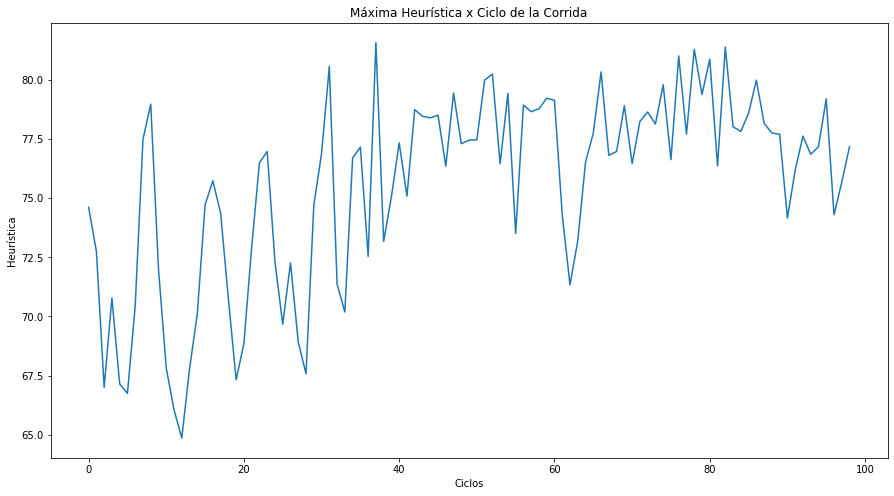

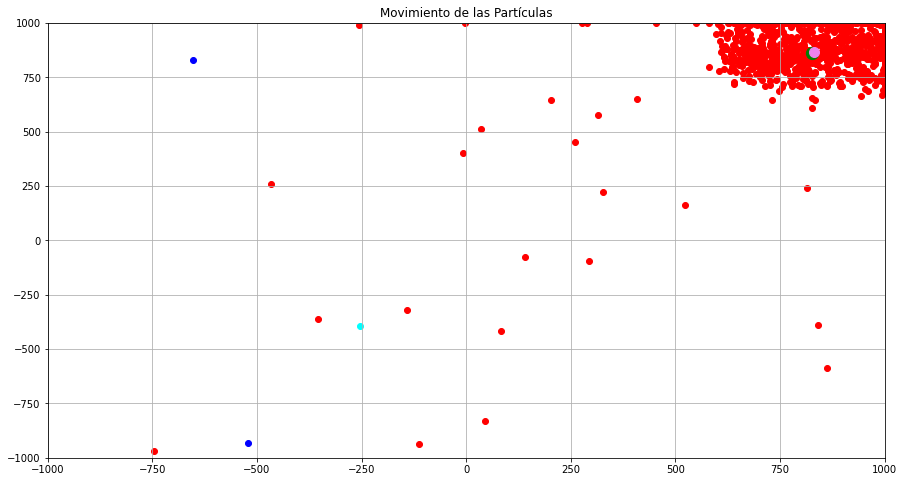

In [14]:
## MOSTRAR GRAFICO DE LA CORRIDA
plt.figure(figsize=(15,8)) 
plt.plot(ciclosMaxAptitud)
plt.title('Máxima Heurística x Ciclo de la Corrida')
plt.xlabel('Ciclos')
plt.ylabel('Heurística')
plt.show()


## MOSTRAR GRAFICO DEL MOVIMIENTO DE LAS PARTICULAS
plt.figure(figsize=(15,8)) 

## --en Rojo: posiciones de las particulas de cada ciclo
for part in ciclosParticulas:
  plt.scatter(part[0], part[1], color='red')

## -- en Azul: Máximos Locales (positivos)
## -- en Cyan: Mínimos Locales (negativos)
## -- en Verde: Máximo Óptimo
for posi, vali in zip(mapa.posMaximos, mapa.valMaximos):    
  if vali < 0:
      plt.scatter(posi[0], posi[1], color='cyan')
  else:
      plt.scatter(posi[0], posi[1], color='blue')
plt.scatter(mapa.posMaximoGlobal[0], mapa.posMaximoGlobal[1], color='green', s=150)    

## --en Violeta: Mejor posición de las partículas
plt.scatter(mejorPartCorrida.posicion[0], mejorPartCorrida.posicion[1], color='violet', s=100)

plt.title('Movimiento de las Partículas')
plt.xlim(MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ)
plt.ylim(MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ)
plt.grid(True)
plt.show()
